In [50]:
from pandas import *
import numpy as np
import os

In [51]:
def process_excel_file(path, sheet):
    read = read_excel(path, sheet, index_col=None, na_values=['NA'])
    df = DataFrame(read)
    df.columns = ['questions', 'label']
    return df

In [52]:
def write_into_text(writePath, label, df):
    with open(writePath, 'w') as f:
        for line in df['questions']:
            f.write(line + '\t' + str(label) + '\n')
            f.flush()
        f.close()

In [53]:
def combine_common_files(file1,file2, final):
    r1 = open(file1, 'r')
    r2 = open(file2, 'r')
    lines1 = r1.readlines()
    lines2 = r2.readlines()
    questions_list = []
    for l in lines1:
        l = l.strip()
        if l not in questions_list:
            questions_list.append(l)
    for l in lines2:
        l = l.strip()
        if l not in questions_list:
            questions_list.append(l)
    w = open(final, 'w')
    for q in questions_list:
        w.write(q + '\n')
        w.flush()
    w.close()

In [54]:
# delete data
writePath = 'chatbot_raw.txt'
os.remove(writePath)

In [55]:
# get the data of chatbot
writePath = 'chatbot_raw.txt'
path, sheet = 'covid_data.xlsx', 'Sheet1'
label = 0
df = process_excel_file(path, sheet)
write_into_text(writePath, label, df)

In [56]:
# combine chatbot data
file1 = writePath
file2 = 'general_dataset.txt'
final_chatbot = 'chatbot_related_dataset_final.txt'
combine_common_files(file1,file2, final_chatbot)

In [57]:
# delete data
writePath = 'covid19_raw.txt'
os.remove(writePath)

In [58]:
# get the data of covid
writePath = 'covid19_raw.txt'
path, sheet = 'covid_data.xlsx', 'Sheet2'
label = 1
df = process_excel_file(path, sheet)
write_into_text(writePath, label, df)

In [59]:
# combine covid data
file1 = writePath
file2 = 'covid_related_dataset.txt'
final_covid = 'covid_related_dataset_final.txt'
combine_common_files(file1,file2, final_covid)

# Data Processing

In [60]:
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression, Perceptron, Lasso
from sklearn.model_selection import train_test_split, LeaveOneOut, cross_val_score,KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot



In [85]:
sdg_params = dict(alpha=1e-5, penalty="l2", loss="log")
vectorizer_params = dict(ngram_range=(1, 2), min_df=5, max_df=0.8, token_pattern=r"(?u)\b\w+\b", stop_words=None, analyzer='word')

def data_processing(file1, file2):
    r1 = open(file1, 'r')
    r2 = open(file2, 'r')
    line1 = r1.readlines()
    line2 = r2.readlines()
    random.shuffle(line1)
    random.shuffle(line2)
    X = []
    y = []
    for l in line1:
        l = l.strip()
        strs = l.split('\t')
        if strs != ['']:
            X.append(strs[0])
            y.append(strs[1])

    for l in line2:
        l = l.strip()
        strs = l.split('\t')
        if strs != ['']:
            X.append(strs[0])
            y.append(strs[1])
    print(len(X), len(y))
    y = np.array(y)

    return X,y

pipeline1 = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("clf", SGDClassifier(**sdg_params)),
]
)

pipeline2 = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("clf", MultinomialNB()),
]
)

pipeline3 = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("clf", LogisticRegression()),
]
)


pipeline4 = Pipeline(
[
    ("vect", CountVectorizer(**vectorizer_params)),
    ("tfidf", TfidfTransformer()),
    ("clf", Perceptron(tol=1e-3, random_state=0)),
]
)

# Plotting ROC curves
def run_auc(clf, X_test, y_test):
    integer = lambda t: int(t)
    y_test = np.vectorize(integer)(y_test)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = clf.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Method in consideration: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(3)
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    print("-" * 10)

def model(clf, X_train, X_test, y_train, y_test):
    print("Number of training samples:", len(X_train))
    print(type(X_train[0]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_check = clf.predict(X_train)
    print(
        "Micro-averaged accuracy score on test set: %0.3f"
        % accuracy_score(y_test, y_pred)
    )
    print(
        "Micro-averaged accuracy score on training set: %0.3f"
        % accuracy_score(y_train, y_check)
    )
    plt.figure(1)
    plot_confusion_matrix(clf, X_test, y_test)
    plt.figure(2)
    plot_confusion_matrix(clf, X_train, y_train)
    plt.show()
    run_auc(clf, X_test, y_test)

    # plt.scatter(y_test, y_pred)
    # plt.savefig('confusion_matrix_new_1.png')
    
   
    
    
def model_cv(clf, X, y):
    print("Number of samples:", len(X))
    print(type(X_train[0]))
    # cv=KFold(n_splits=5)
    cv = LeaveOneOut()
    score = cross_val_score(clf,X,y, cv=cv)
    print("Average Cross Validation score :{}".format(score.mean()))

839 839
check the 1st pipeline model: SGD classifier
Number of samples: 839
<class 'str'>
Average Cross Validation score :0.8557806912991657
Number of training samples: 629
<class 'str'>
Micro-averaged accuracy score on test set: 0.833
Micro-averaged accuracy score on training set: 0.963


<Figure size 432x288 with 0 Axes>

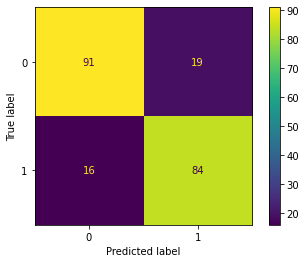

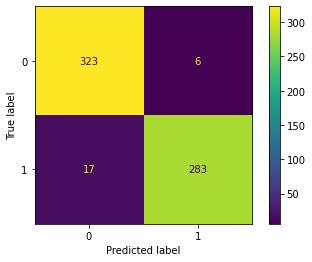

No Skill: ROC AUC=0.500
Method in consideration: ROC AUC=0.905


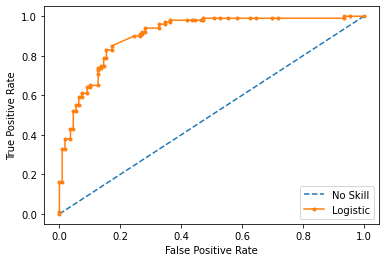

----------
check the 2nd pipeline model: naive bayes
Number of samples: 839
<class 'str'>
Average Cross Validation score :0.8545887961859356
Number of training samples: 629
<class 'str'>
Micro-averaged accuracy score on test set: 0.824
Micro-averaged accuracy score on training set: 0.890


<Figure size 432x288 with 0 Axes>

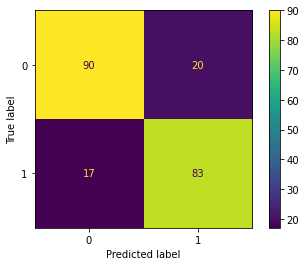

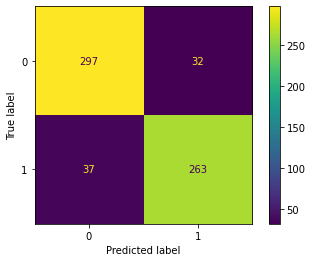

No Skill: ROC AUC=0.500
Method in consideration: ROC AUC=0.922


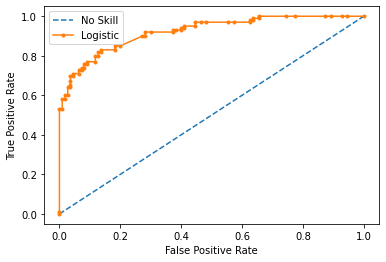

----------
check the 3rd pipeline model: Losgistic regression
Number of samples: 839
<class 'str'>
Average Cross Validation score :0.8700834326579261
Number of training samples: 629
<class 'str'>
Micro-averaged accuracy score on test set: 0.857
Micro-averaged accuracy score on training set: 0.914


<Figure size 432x288 with 0 Axes>

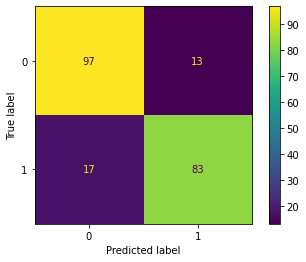

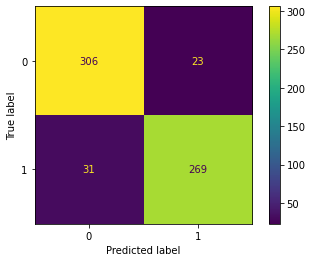

No Skill: ROC AUC=0.500
Method in consideration: ROC AUC=0.932


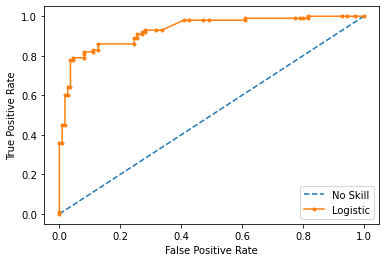

----------


In [86]:
if __name__ == '__main__':
    final_chatbot = 'chatbot_related_dataset_final.txt'
    final_covid = 'covid_related_dataset_final.txt'

    # Check the overall performance of the model by LLO
    X,y = data_processing(final_chatbot, final_covid)
    
    
    # check the training and testing score of the model
    print("check the 1st pipeline model: SGD classifier")
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    model_cv(pipeline1, X, y)
    model(pipeline1, X_train, X_test, y_train, y_test)
    
    # check the training and testing score of the model
    print("check the 2nd pipeline model: naive bayes")
    model_cv(pipeline2, X, y)
    model(pipeline2, X_train, X_test, y_train, y_test)
    
    # check the training and testing score of the model
    print("check the 3rd pipeline model: Losgistic regression")
    model_cv(pipeline3, X, y)
    model(pipeline3, X_train, X_test, y_train, y_test)

In [ ]:
## 129 class 0, 179 class 1
# 770 770
# 577 577 193 193
# Number of training samples: 577
# <class 'str'>
# Micro-averaged accuracy score on test set: 0.788
# Micro-averaged F1 score on test set: 0.788
# ----------

# LOO score = 0.8558441558441559

# Average Cross Validation score :0.8682385575589459
## 129 -> class 0 and class 1

